# 🧠 Análisis de la Readmisión a la UCI en Pacientes con Hemorragia Intracerebral (MIMIC-IV)

## 1. 🔧 Configuración Inicial

In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account

# Path to your service account key file
SERVICE_ACCOUNT_FILE = "mimic-sergi.json"
PROJECT_ID = "ogi-uci-i61"

# Create credentials and client
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE)

client = bigquery.Client(credentials=credentials, project=PROJECT_ID)

# Example query
query = "SELECT 'Hello, World!' AS greeting"
query_job = client.query(query)

# Fetch results
results = query_job.result()

for row in results:
    print(row.greeting)

Hello, World!


## 2. 📦 Extracción de Datos

In [ ]:
# SQL query para extraer datos de pacientes con HIC (Hemorragia Intracerebral) en la UCI
query = """
-- Updated SQL query for ICH patients in ICU with corrected joins to derived lab tables
WITH ich_admissions AS (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd` i
  JOIN `ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses` d
    ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version
  WHERE LOWER(d.long_title) LIKE '%intracerebral hemorrhage%'
),

chartevents_avg AS (
  SELECT
    c.stay_id,
    AVG(CASE WHEN itemid = 220045 AND valuenum > 0 THEN valuenum END) AS heart_rate_avg,
    AVG(CASE WHEN itemid = 220052 AND valuenum BETWEEN 30 AND 200 THEN valuenum END) AS mbp_avg,
    AVG(CASE WHEN itemid = 220210 AND valuenum BETWEEN 5 AND 60 THEN valuenum END) AS resp_rate_avg,
    AVG(CASE WHEN itemid = 220277 AND valuenum BETWEEN 70 AND 100 THEN valuenum END) AS spo2_avg,
  FROM `ogi-uci-i61.mimiciv_icu.chartevents` c
  JOIN `ogi-uci-i61.mimiciv_icu.icustays` i ON c.stay_id = i.stay_id
  WHERE
    c.itemid IN (220045, 220052, 220210, 220277, 223762)
    AND c.valuenum IS NOT NULL
    AND c.charttime BETWEEN i.intime AND i.outtime
  GROUP BY c.stay_id
),

cbc_labs AS (
  SELECT subject_id, hadm_id,
    MIN(wbc) AS wbc_min,
    MIN(hemoglobin) AS hgb_min,
    MIN(hematocrit) AS hct_min
  FROM `ogi-uci-i61.mimiciv_derived.complete_blood_count`
  GROUP BY subject_id, hadm_id
),

chem_labs AS (
  SELECT subject_id, hadm_id,
    MIN(sodium) AS sodium_min,
    MIN(creatinine) AS creatinine_min,
    MIN(glucose) AS glucose_min
  FROM `ogi-uci-i61.mimiciv_derived.chemistry`
  GROUP BY subject_id, hadm_id
),

coag_labs AS (
  SELECT subject_id, hadm_id,
    MIN(inr) AS inr_min,
    MIN(pt) AS pt_min
  FROM `ogi-uci-i61.mimiciv_derived.coagulation`
  GROUP BY subject_id, hadm_id
),

readmission_within_30_days AS (
  SELECT
    a1.subject_id,
    a1.stay_id,
    MIN(a2.stay_id) AS readmitted_stay
  FROM `ogi-uci-i61.mimiciv_icu.icustays` a1
  JOIN `ogi-uci-i61.mimiciv_icu.icustays` a2
    ON a1.subject_id = a2.subject_id
    AND a2.intime > a1.outtime
    AND DATETIME_DIFF(a2.intime, a1.outtime, DAY) <= 30
  GROUP BY a1.subject_id, a1.stay_id
)

SELECT
  a.subject_id,
  a.hadm_id,
  a.stay_id,
  p.gender,
  p.anchor_age AS age,
  a.intime,
  a.outtime,
  a.first_careunit,
  TIMESTAMP_DIFF(a.outtime, a.intime, HOUR) AS icu_los_hours,
  TIMESTAMP_DIFF(adm.dischtime, adm.admittime, HOUR) AS hosp_los_hours,
  adm.discharge_location,
  adm.hospital_expire_flag,

  STRING_AGG(CASE WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' THEN i.icd_code END, '; ') AS ich_icd_codes,
  STRING_AGG(CASE WHEN LOWER(d.long_title) LIKE '%intracerebral hemorrhage%' THEN CONCAT(i.icd_code, ': ', d.long_title) ELSE i.icd_code END, '; ') AS all_diagnoses,

  s.gcs_verbal,
  s.gcs_motor,
  s.gcs_eyes,

  vitals.heart_rate,
  vitals.mbp,
  vitals.resp_rate,
  vitals.spo2,
  ce.heart_rate_avg,
  ce.mbp_avg,
  ce.resp_rate_avg,
  ce.spo2_avg,

  -- Derived Scores and Labs
  charlson.charlson_comorbidity_index,
  apsi.apsiii,
  code_status.dnr,
  code_status.dni,
  code_status.fullcode,
  code_status.cmo,
  cbc.wbc_min, cbc.hgb_min, cbc.hct_min,
  chem.sodium_min, chem.creatinine_min, chem.glucose_min,
  coag.inr_min, coag.pt_min,

  CASE WHEN hyper.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hypertension,
  CASE WHEN hydro.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_hydrocephalus,
  CASE WHEN cad.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS has_cad,
  CASE WHEN anticoag.subject_id IS NOT NULL THEN 1 ELSE 0 END AS has_anticoagulation,
  CASE WHEN neuroproc.hadm_id IS NOT NULL THEN 1 ELSE 0 END AS had_neurosurgery,
  CASE WHEN addmeds.subject_id IS NOT NULL THEN 1 ELSE 0 END AS on_statins_or_antiplatelets,

  readmit.readmitted_stay

FROM `ogi-uci-i61.mimiciv_icu.icustays` a
JOIN `ogi-uci-i61.mimiciv_hosp.patients` p ON a.subject_id = p.subject_id
JOIN `ogi-uci-i61.mimiciv_hosp.admissions` adm ON a.hadm_id = adm.hadm_id
JOIN ich_admissions ich ON a.hadm_id = ich.hadm_id
LEFT JOIN `ogi-uci-i61.mimiciv_hosp.diagnoses_icd` i ON a.hadm_id = i.hadm_id
LEFT JOIN `ogi-uci-i61.mimiciv_hosp.d_icd_diagnoses` d ON i.icd_code = d.icd_code AND i.icd_version = d.icd_version

LEFT JOIN (
  SELECT stay_id, gcs_verbal, gcs_motor, gcs_eyes,
         ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM `ogi-uci-i61.mimiciv_derived.gcs`
) s ON a.stay_id = s.stay_id AND s.rn = 1

LEFT JOIN (
  SELECT stay_id, heart_rate, mbp, resp_rate, spo2,
         ROW_NUMBER() OVER (PARTITION BY stay_id ORDER BY charttime) AS rn
  FROM `ogi-uci-i61.mimiciv_derived.vitalsign`
) vitals ON a.stay_id = vitals.stay_id AND vitals.rn = 1

LEFT JOIN chartevents_avg ce ON a.stay_id = ce.stay_id
LEFT JOIN readmission_within_30_days readmit ON a.subject_id = readmit.subject_id AND a.stay_id = readmit.stay_id

-- Derived Scores and Corrected Lab Joins
LEFT JOIN `ogi-uci-i61.mimiciv_derived.charlson` charlson ON a.hadm_id = charlson.hadm_id
LEFT JOIN `ogi-uci-i61.mimiciv_derived.apsiii` apsi ON a.stay_id = apsi.stay_id
LEFT JOIN `ogi-uci-i61.mimiciv_derived.code_status` code_status ON a.stay_id = code_status.stay_id
LEFT JOIN cbc_labs cbc ON a.subject_id = cbc.subject_id AND a.hadm_id = cbc.hadm_id
LEFT JOIN chem_labs chem ON a.subject_id = chem.subject_id AND a.hadm_id = chem.hadm_id
LEFT JOIN coag_labs coag ON a.subject_id = coag.subject_id AND a.hadm_id = coag.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '401%' OR icd_code LIKE 'I10%'
) hyper ON a.hadm_id = hyper.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '331.3' OR icd_code LIKE 'G91%'
) hydro ON a.hadm_id = hydro.hadm_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.diagnoses_icd`
  WHERE icd_code LIKE '414%' OR icd_code LIKE 'I25%'
) cad ON a.hadm_id = cad.hadm_id

LEFT JOIN (
  SELECT DISTINCT subject_id
  FROM `ogi-uci-i61.mimiciv_hosp.prescriptions`
  WHERE REGEXP_CONTAINS(LOWER(drug), r'(warfarin|heparin|apixaban|rivaroxaban|dabigatran)')
    AND drug_type = 'MAIN'
) anticoag ON a.subject_id = anticoag.subject_id

LEFT JOIN (
  SELECT DISTINCT subject_id
  FROM `ogi-uci-i61.mimiciv_hosp.prescriptions`
  WHERE REGEXP_CONTAINS(LOWER(drug), r'(aspirin|clopidogrel|atorvastatin|rosuvastatin)')
    AND drug_type = 'MAIN'
) addmeds ON a.subject_id = addmeds.subject_id

LEFT JOIN (
  SELECT DISTINCT hadm_id
  FROM `ogi-uci-i61.mimiciv_hosp.procedures_icd`
  WHERE icd_code LIKE '01%' OR icd_code LIKE '02%'
) neuroproc ON a.hadm_id = neuroproc.hadm_id

GROUP BY
  a.subject_id, a.hadm_id, a.stay_id, a.intime, a.outtime, a.first_careunit,
  p.gender, p.anchor_age, adm.admittime, adm.dischtime, adm.discharge_location, adm.hospital_expire_flag,
  s.gcs_verbal, s.gcs_motor, s.gcs_eyes,
  vitals.heart_rate, vitals.mbp, vitals.resp_rate, vitals.spo2,
  ce.heart_rate_avg, ce.mbp_avg, ce.resp_rate_avg, ce.spo2_avg,
  charlson.charlson_comorbidity_index,
  apsi.apsiii,
  code_status.dnr, code_status.dni, code_status.fullcode, code_status.cmo,
  cbc.wbc_min, cbc.hgb_min, cbc.hct_min,
  chem.sodium_min, chem.creatinine_min, chem.glucose_min,
  coag.inr_min, coag.pt_min,
  hyper.hadm_id, hydro.hadm_id, cad.hadm_id,
  anticoag.subject_id, addmeds.subject_id, neuroproc.hadm_id,
  readmit.readmitted_stay

"""

# Ejecutar la consulta
df = client.query(query).to_dataframe()

df

,subject_id,hadm_id,stay_id,gender,age,intime,outtime,first_careunit,icu_los_hours,hosp_los_hours,...,glucose_min,inr_min,pt_min,has_hypertension,has_hydrocephalus,has_cad,has_anticoagulation,had_neurosurgery,on_statins_or_antiplatelets,readmitted_stay
0,19999987,23865745,36195440,F,57,2145-11-02 22:59:00,2145-11-04 21:29:30,Trauma SICU (TSICU),47,207,...,90.0,1.1,11.6,0,0,1,1,0,0,<NA>
1,11342786,25378669,38543513,F,67,2117-10-19 05:18:26,2117-10-19 05:32:56,Surgical Intensive Care Unit (SICU),0,199,...,83.0,1.2,13.3,0,0,1,1,0,1,31028998
2,19125737,23546213,36381929,F,87,2117-08-06 17:38:00,2117-08-09 06:55:00,Trauma SICU (TSICU),61,59,...,126.0,1.0,11.1,0,0,0,1,0,0,<NA>
3,19589948,27687194,34614771,F,88,2187-06-25 07:19:55,2187-06-26 12:00:41,Surgical Intensive Care Unit (SICU),29,273,...,98.0,1.1,11.5,0,0,0,1,1,0,<NA>
4,14179163,21828464,37204544,F,80,2185-04-07 13:03:43,2185-04-16 14:23:30,Surgical Intensive Care Unit (SICU),217,338,...,95.0,1.1,11.7,1,0,0,1,1,1,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247,19636477,21311090,30996447,F,73,2199-02-06 07:59:00,2199-02-08 16:49:27,Surgical Intensive Care Unit (SICU),57,103,...,97.0,1.1,11.5,1,0,0,1,0,1,<NA>
4248,14674473,22167005,35907408,M,81,2134-04-02 07:59:27,2134-04-10 13:40:20,Neuro Intermediate,198,198,...,90.0,1.1,11.7,0,0,0,1,0,1,<NA>
4249,12290708,22330584,30468327,F,89,2129-10-24 07:44:00,2129-10-24 23:51:32,Medical/Surgical Intensive Care Unit (MICU/SICU),16,115,...,114.0,NaN,NaN,0,0,0,1,0,0,<NA>
4250,12759938,20352762,30761846,F,75,2164-10-26 03:10:00,2164-10-29 16:36:06,Neuro Intermediate,85,108,...,99.0,1.0,10.9,1,0,0,1,0,0,<NA>


## 3. 🧽 Preprocesamiento

In [4]:
import pandas as pd

# Remove patients who died in the hospital
df = df[df['hospital_expire_flag'] == 0]
print(f"Remaining patients after removing in-hospital deaths: {len(df)}")

# Create target variable (readmitted)
print("\nNulls in readmitted_stay before fillna:", df['readmitted_stay'].isnull().sum())

# Check how many unique stay IDs there are
unique_stay_ids = df['stay_id'].nunique()
print(f"\nNumber of unique stay IDs: {unique_stay_ids}")

# Check for duplicate stay IDs (if any)
duplicate_stay_ids = df['stay_id'].duplicated().sum()
print(f"Number of duplicate stay IDs: {duplicate_stay_ids}")

# Check how many unique hadm IDs there are
unique_hadm_ids = df['hadm_id'].nunique()
print(f"\nNumber of unique hadm IDs: {unique_hadm_ids}")

# Check for duplicate stay IDs (if any)
duplicate_hadm_ids = df['hadm_id'].duplicated().sum()
print(f"Number of duplicate hadm IDs: {duplicate_hadm_ids}")


# Define readmitted (1 if readmitted_stay is not null, 0 otherwise)
df['readmitted'] = df['readmitted_stay'].notnull().astype(int)  # Or (df['readmitted_stay'] > 0).astype(int)
print("Class distribution in readmitted:", df['readmitted'].value_counts())

# Explicitly convert icu_los_hours to numerical type
df['icu_los_hours'] = pd.to_numeric(df['icu_los_hours'])

# Convert to categorical 
df['gcs_verbal'] = df['gcs_verbal'].astype('category')
df['gcs_motor'] = df['gcs_motor'].astype('category')
df['gcs_eyes'] = df['gcs_eyes'].astype('category')
df['gender'] = df['gender'].astype('category')

# Split semicolon-separated codes into lists for all diagnoses
df['all_diagnoses_list'] = df['all_diagnoses'].str.split(';')

# Get all ICD codes and their frequencies
all_codes = df['all_diagnoses_list'].explode().str.strip()
# Extract just the ICD code (before the colon, if present)
all_codes = all_codes.str.split(':').str[0].str.strip()
all_codes = all_codes[all_codes != '']  # Exclude empty strings

# Filter out ICH-related codes
# Assuming ICH codes are those in ich_icd_codes or identified by the SQL condition
ich_codes = df['ich_icd_codes'].str.split(';').explode().str.strip().unique()
ich_codes = [code for code in ich_codes if code]  # Remove empty strings
non_ich_codes = all_codes[~all_codes.isin(ich_codes)]

# Get frequency of non-ICH codes
non_ich_code_counts = non_ich_codes.value_counts()

# Identify the 10 most frequent non-ICH codes
top_10_non_ich_codes = non_ich_code_counts.head(20).index.tolist()
print(f"\nTop 10 most frequent non-ICH ICD-10 codes: {top_10_non_ich_codes}")
print("Frequency of non-ICH codes:")
print(non_ich_code_counts.head(20))

# One-hot encode the top 10 non-ICH codes
for code in top_10_non_ich_codes:
    df[f'non_ich_{code}'] = df['all_diagnoses'].str.contains(code, na=False).astype(int)

# Drop temporary column
df = df.drop(columns=['all_diagnoses_list'], errors='ignore')

# Optionally, if you still want to one-hot encode ICH codes (as in your original code)
df['ich_icd_codes_list'] = df['ich_icd_codes'].str.split(';')
all_ich_codes = df['ich_icd_codes_list'].explode().str.strip()
all_ich_codes = all_ich_codes[all_ich_codes != '']
ich_code_counts = all_ich_codes.value_counts()
top_7_ich_codes = ich_code_counts.head(7).index.tolist()
print(f"\nTop 7 most frequent ICH ICD-10 codes: {top_7_ich_codes}")
print("Frequency of ICH codes:")
print(ich_code_counts)

for code in top_7_ich_codes:
    df[f'ich_{code}'] = df['ich_icd_codes'].str.contains(code, na=False).astype(int)

# Drop temporary ICH column
df = df.drop(columns=['ich_icd_codes_list'], errors='ignore')

df

Remaining patients after removing in-hospital deaths: 3047

Nulls in readmitted_stay before fillna: 2573

Number of unique stay IDs: 2857
Number of duplicate stay IDs: 190

Number of unique hadm IDs: 2538
Number of duplicate hadm IDs: 509
Class distribution in readmitted: readmitted
0    2573
1     474
Name: count, dtype: int64

Top 10 most frequent non-ICH ICD-10 codes: ['I10', 'E785', 'G936', '4019', 'R29810', 'Z781', 'R1310', '3485', 'N390', 'Z66', 'R4701', 'G8194', 'Z87891', 'R471', '2724', 'E870', 'Z20822', 'J9601', 'N179', 'G8191']
Frequency of non-ICH codes:
all_diagnoses_list
I10       1744
E785      1350
G936      1307
4019      1246
R29810     961
Z781       811
R1310      789
3485       776
N390       745
Z66        731
R4701      711
G8194      704
Z87891     700
R471       610
2724       599
E870       591
Z20822     578
J9601      557
N179       535
G8191      525
Name: count, dtype: int64

Top 7 most frequent ICH ICD-10 codes: ['431', 'I618', 'I615', 'I611', 'I619', 'I61

/var/folders/7f/96n2ywnj6sl2ftr3st6bjp640000gn/T/ipykernel_77038/3816621475.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['readmitted'] = df['readmitted_stay'].notnull().astype(int)  # Or (df['readmitted_stay'] > 0).astype(int)
/var/folders/7f/96n2ywnj6sl2ftr3st6bjp640000gn/T/ipykernel_77038/3816621475.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['icu_los_hours'] = pd.to_numeric(df['icu_los_hours'])
/var/folders/7f/96n2ywnj6sl2ftr3st6bjp640000gn/T/ipykernel_77038/3816621475.py:35: Setti

,subject_id,hadm_id,stay_id,gender,age,intime,outtime,first_careunit,icu_los_hours,hosp_los_hours,...,non_ich_J9601,non_ich_N179,non_ich_G8191,ich_431,ich_I618,ich_I615,ich_I611,ich_I619,ich_I610,ich_I614
0,19999987,23865745,36195440,F,57,2145-11-02 22:59:00,2145-11-04 21:29:30,Trauma SICU (TSICU),47,207,...,0,0,0,1,0,0,0,0,0,0
1,11342786,25378669,38543513,F,67,2117-10-19 05:18:26,2117-10-19 05:32:56,Surgical Intensive Care Unit (SICU),0,199,...,0,0,0,0,0,0,0,1,0,0
4,14179163,21828464,37204544,F,80,2185-04-07 13:03:43,2185-04-16 14:23:30,Surgical Intensive Care Unit (SICU),217,338,...,0,0,0,1,0,0,0,0,0,0
5,13510036,24065970,32518487,M,79,2174-04-02 05:06:00,2174-04-19 01:23:06,Neuro Intermediate,404,446,...,0,0,0,0,1,0,0,0,0,0
6,16802438,22838118,36434166,M,54,2128-02-20 19:56:43,2128-02-22 23:20:13,Neuro Stepdown,52,983,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,16135260,23716144,31099829,M,78,2139-07-05 17:11:28,2139-07-08 22:04:18,Neuro Intermediate,77,285,...,0,0,1,0,0,0,1,0,0,0
4246,11634289,29125015,39342370,M,78,2161-10-26 12:38:27,2161-11-05 17:28:32,Neuro Surgical Intensive Care Unit (Neuro SICU),245,743,...,0,0,0,0,0,1,0,0,0,0
4247,19636477,21311090,30996447,F,73,2199-02-06 07:59:00,2199-02-08 16:49:27,Surgical Intensive Care Unit (SICU),57,103,...,0,0,0,1,0,0,0,0,0,0
4248,14674473,22167005,35907408,M,81,2134-04-02 07:59:27,2134-04-10 13:40:20,Neuro Intermediate,198,198,...,0,0,0,0,0,0,0,1,0,0


In [5]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Primer hauríem de mirar quins tipus de dades conté cada columna
print(df.dtypes)



subject_id       Int64
hadm_id          Int64
stay_id          Int64
gender        category
age              Int64
                ...   
ich_I615         int64
ich_I611         int64
ich_I619         int64
ich_I610         int64
ich_I614         int64
Length: 76, dtype: object


## 4. 📊 Modelado Predictivo

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from decimal import Decimal

# Calculate missing percentages
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
print("Missing percentages per column:")
print(missing_pct.sort_values(ascending=False))

# Set missing data threshold
missing_threshold = 60  # Exclude columns with >60% missing
columns_to_exclude = missing_pct[missing_pct > missing_threshold].index
print(f"\nColumns with >{missing_threshold}% missing: {list(columns_to_exclude)}")

# Exclude high-missingness columns, but keep readmitted_stay for target creation
features_to_keep = [col for col in df.columns if col not in columns_to_exclude or col == 'readmitted_stay']
df_clean = df.loc[:, features_to_keep]

# Handle Decimal values and fill NaNs
# Convert Decimal to float for numerical columns
numerical_cols = df_clean.select_dtypes(include=['number', 'Int64', 'float64', 'int64']).columns
for col in numerical_cols:
    df_clean.loc[:, col] = df_clean[col].apply(lambda x: float(x) if isinstance(x, Decimal) else x)

# Identify integer columns
int_columns = df_clean.select_dtypes(include=['Int64', 'int64']).columns
# Fill NaNs with rounded medians for integer columns
for col in int_columns:
    median_val = df_clean[col].median()
    if not pd.isna(median_val):
        df_clean.loc[:, col] = df_clean[col].fillna(int(median_val))

# Fill NaNs for other numeric columns, excluding readmitted_stay and readmitted
numeric_cols = df_clean.select_dtypes(include='number').columns.difference(['readmitted_stay', 'readmitted'])
df_clean.loc[:, numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())

# Handle readmitted_stay separately
df_clean.loc[:, 'readmitted_stay'] = df_clean['readmitted_stay'].fillna(0)

# Scale features
scaler = StandardScaler()
feature_cols = df_clean.select_dtypes(include='number').columns[
    ~df_clean.select_dtypes(include='number').columns.str.startswith(('non_ich', 'ich'))
].difference(['readmitted_stay', 'readmitted', 'subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'has_hypertension', 'has_hydrocephalus', 'has_cad', 'has_anticoagulation', 'had_neurosurgery'])
features_scaled = scaler.fit_transform(df_clean[feature_cols])
df_clean.loc[:, feature_cols] = features_scaled

# Remove columns that are not needed for the final dataset 
df_clean = df_clean.drop(columns=['intime', 'outtime', 'subject_id', 'hadm_id', 'stay_id', 'readmitted_stay', 'all_diagnoses','ich_icd_codes'], errors='ignore')

df_clean


Missing percentages per column:
temperature_avg                94.95
readmitted_stay                84.44
mbp                            76.80
temperature                    75.12
mbp_avg                        63.73
                               ...  
has_anticoagulation             0.00
had_neurosurgery                0.00
on_statins_or_antiplatelets     0.00
readmitted                      0.00
ich_I614                        0.00
Length: 76, dtype: float64

Columns with >60% missing: ['mbp', 'temperature', 'mbp_avg', 'temperature_avg', 'readmitted_stay']


,gender,age,first_careunit,icu_los_hours,hosp_los_hours,discharge_location,hospital_expire_flag,gcs_verbal,gcs_motor,gcs_eyes,...,non_ich_J9601,non_ich_N179,non_ich_G8191,ich_431,ich_I618,ich_I615,ich_I611,ich_I619,ich_I610,ich_I614
0,F,-0.576412,Trauma SICU (TSICU),-0.580247,-0.390636,REHAB,0,0.0,4.0,1.0,...,0,0,0,1,0,0,0,0,0,0
1,F,0.060331,Surgical Intensive Care Unit (SICU),-0.842865,-0.408808,REHAB,0,5.0,6.0,4.0,...,0,0,0,0,0,0,0,1,0,0
4,F,0.888096,Surgical Intensive Care Unit (SICU),0.369648,-0.093066,SKILLED NURSING FACILITY,0,0.0,4.0,2.0,...,0,0,0,1,0,0,0,0,0,0
5,M,0.824422,Neuro Intermediate,1.414533,0.152259,REHAB,0,5.0,6.0,3.0,...,0,0,0,0,1,0,0,0,0,0
6,M,-0.767434,Neuro Stepdown,-0.552309,1.372070,REHAB,0,4.0,6.0,4.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,M,0.760747,Neuro Intermediate,-0.412618,-0.213457,REHAB,0,3.0,6.0,4.0,...,0,0,1,0,0,0,1,0,0,0
4246,M,0.760747,Neuro Surgical Intensive Care Unit (Neuro SICU),0.526102,0.826903,SKILLED NURSING FACILITY,0,2.0,5.0,4.0,...,0,0,0,0,0,1,0,0,0,0
4247,F,0.442376,Surgical Intensive Care Unit (SICU),-0.524371,-0.626875,REHAB,0,5.0,6.0,4.0,...,0,0,0,1,0,0,0,0,0,0
4248,M,0.951770,Neuro Intermediate,0.263484,-0.411080,REHAB,0,5.0,6.0,4.0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from pycaret.classification import *

# Prepare data for PyCaret
ordinal_features = {
    'gcs_verbal': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
    'gcs_motor':  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
    'gcs_eyes':   [0.0, 1.0, 2.0, 3.0, 4.0]
}
feature_cols = df_clean.columns.difference(['readmitted'])
X = df_clean[feature_cols]
y = df_clean['readmitted']
print("y value counts:", y.value_counts())
print("y unique values:", y.unique())

clf_setup = setup(
    data=df_clean,
    target='readmitted',
    ordinal_features=ordinal_features,
    normalize=False,
    session_id=42,
    fix_imbalance=True,
)

y value counts: readmitted
0    2573
1     474
Name: count, dtype: int64
y unique values: [0 1]


,Description,Value
0,Session id,42
1,Target,readmitted
2,Target type,Binary
3,Original data shape,"(3047, 64)"
4,Transformed data shape,"(4515, 97)"
5,Transformed train set shape,"(3600, 97)"
6,Transformed test set shape,"(915, 97)"
7,Ordinal features,3
8,Numeric features,57
9,Categorical features,6


In the initial round of model evaluation, most classifiers achieved high accuracy (around 77%) but extremely low recall and F1 scores. This indicated that the models were predominantly predicting the majority class (i.e., not readmitted), failing to identify actual readmission cases. For example, Ridge Classifier and Logistic Regression had recall values below 2%, and the Dummy Classifier set a high baseline accuracy simply by predicting all negatives. These results highlighted the impact of class imbalance and the need for better strategies to detect minority class cases.

In [8]:
# Paso 4: Comparar Modelos
print("\nComparant models........ esperant........ pot tardar uns minuts...")
best_model = compare_models()


Comparant models........ esperant........ pot tardar uns minuts...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.8443,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0320
lightgbm,Light Gradient Boosting Machine,0.8434,0.7036,0.2110,0.5086,0.2959,0.2239,0.2529,0.3390
et,Extra Trees Classifier,0.8415,0.6794,0.1956,0.4867,0.2752,0.2045,0.2331,0.0740
rf,Random Forest Classifier,0.8363,0.7129,0.2168,0.4472,0.2891,0.2100,0.2286,0.1170
gbc,Gradient Boosting Classifier,0.8340,0.7013,0.1929,0.4440,0.2654,0.1875,0.2102,0.3360
ada,Ada Boost Classifier,0.7805,0.6678,0.2657,0.2793,0.2711,0.1427,0.1431,0.1100
dt,Decision Tree Classifier,0.7467,0.5686,0.3101,0.2481,0.2742,0.1237,0.1255,0.0300
svm,SVM - Linear Kernel,0.6694,0.6205,0.4487,0.2315,0.2954,0.1171,0.1296,0.0300
lr,Logistic Regression,0.6656,0.6782,0.5245,0.2386,0.3272,0.1446,0.1653,0.2940
ridge,Ridge Classifier,0.6647,0.6758,0.5275,0.2392,0.3284,0.1456,0.1663,0.0240


<Axes: >

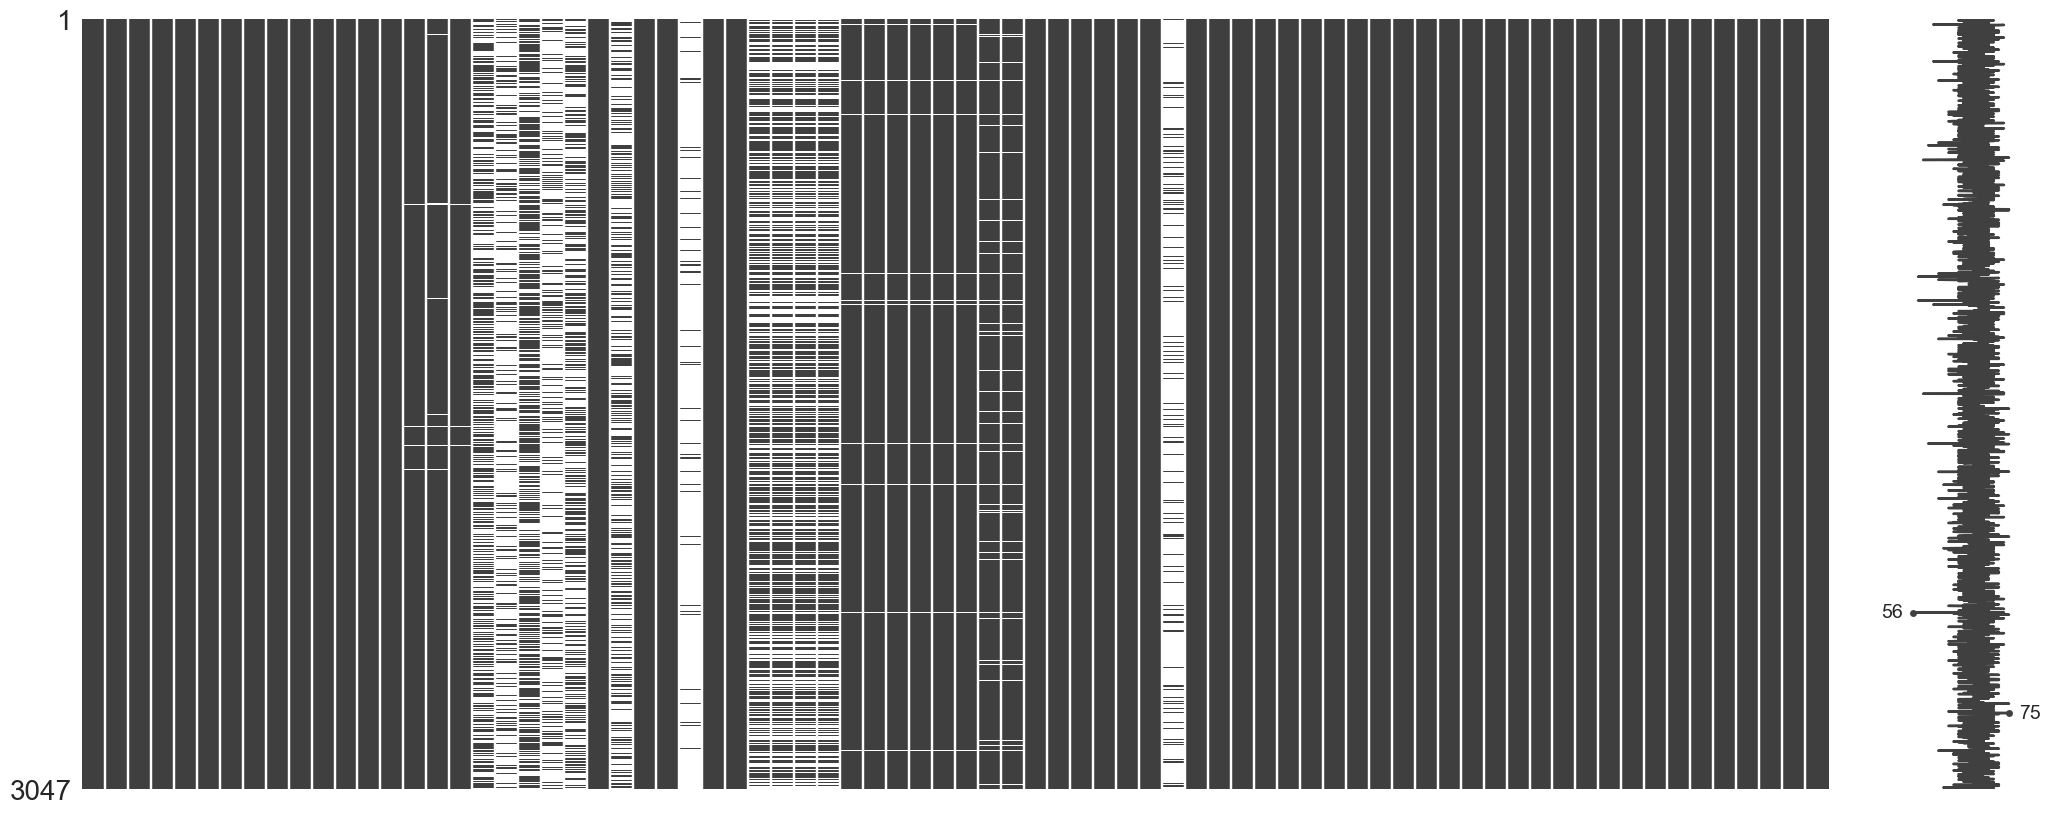

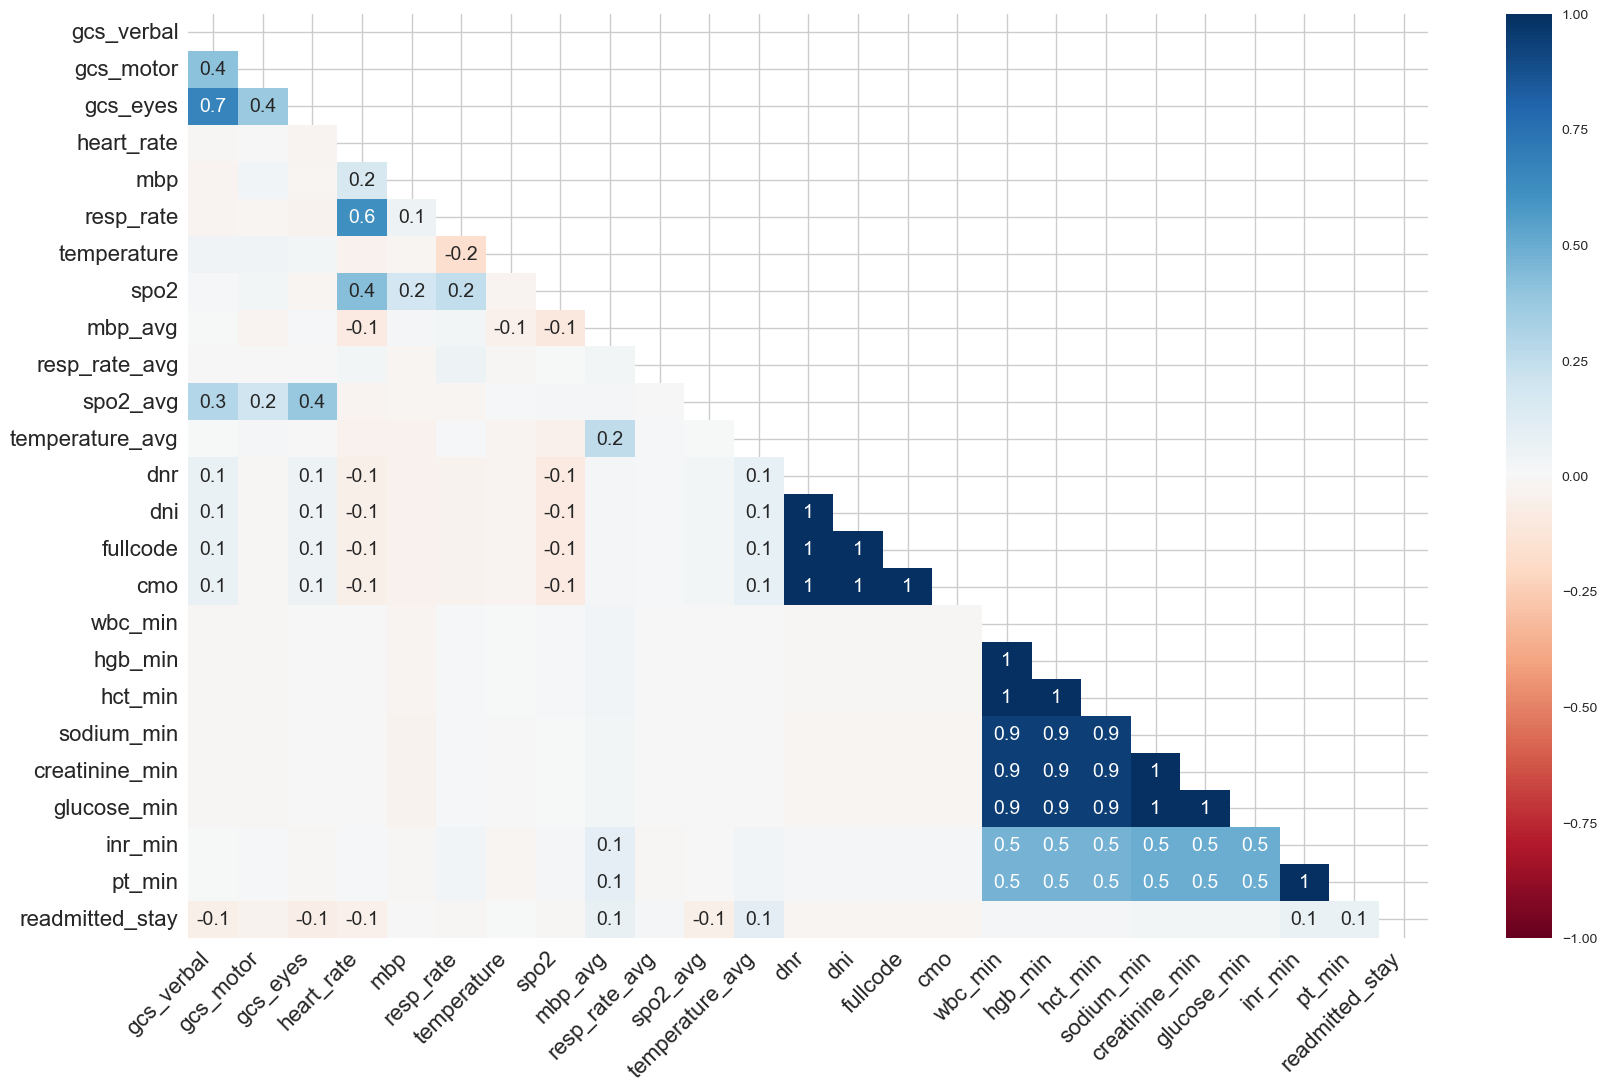

In [31]:
# Analitzem si els missings són per MCAR

import missingno as msno
msno.matrix(df)  # Busca patrons visuals (ex: columnes amb missings correlacionades)

# Heatmap: correlations of missingness
msno.heatmap(df)


MCAR (Missing Completely At Random):
Els valors missing són independents de qualsevol altra variable (observada o no).
Exemple: Un sensor que falla aleatòriament sense patró.
Comprovar-ho: Compara la distribució de les dades completes amb les incompletes (per exemple, amb un test t o KS). Si són similars, potser és MCAR.

No sembla que siguin de tipus MCAR ja que es veu bastanta correlativitat entre les dades faltants.

Provem altres proves.

In [18]:
from scipy.stats import chi2_contingency

# Loop through numeric variables with missing values
numeric_with_missing = df.select_dtypes(include='number').columns[df.select_dtypes(include='number').isnull().any()]


for col in numeric_with_missing:
    # Create a missingness indicator: 1 if missing, 0 if not
    missing_flag = df[col].isnull().astype(int)
    
    # Create a contingency table: missingness vs readmitted
    contingency = pd.crosstab(missing_flag, df['readmitted'])

    # Run chi-squared test
    if contingency.shape == (2, 2):  # Only test if both 0 and 1 present in both
        chi2, p, _, _ = chi2_contingency(contingency)
        print(f"{col}: p = {p:.4f}")
        if p < 0.05:
            print(f" --> Missingness in `{col}` is associated with `readmitted` (not MCAR).")
        else:
            print(f" --> No significant link between missingness in `{col}` and `readmitted` (possibly MCAR).")


heart_rate: p = 0.0053
 --> Missingness in `heart_rate` is associated with `readmitted` (not MCAR).
mbp: p = 0.8606
 --> No significant link between missingness in `mbp` and `readmitted` (possibly MCAR).
resp_rate: p = 0.4996
 --> No significant link between missingness in `resp_rate` and `readmitted` (possibly MCAR).
spo2: p = 0.6081
 --> No significant link between missingness in `spo2` and `readmitted` (possibly MCAR).
mbp_avg: p = 0.0000
 --> Missingness in `mbp_avg` is associated with `readmitted` (not MCAR).
resp_rate_avg: p = 0.7315
 --> No significant link between missingness in `resp_rate_avg` and `readmitted` (possibly MCAR).
spo2_avg: p = 0.0203
 --> Missingness in `spo2_avg` is associated with `readmitted` (not MCAR).
temperature_avg: p = 0.0000
 --> Missingness in `temperature_avg` is associated with `readmitted` (not MCAR).
dnr: p = 0.2693
 --> No significant link between missingness in `dnr` and `readmitted` (possibly MCAR).
dni: p = 0.2693
 --> No significant link betwe

In [29]:
from scipy.stats import chi2_contingency, ttest_ind, ks_2samp

# Loop through numeric variables with missing values
numeric_with_missing = df.select_dtypes(include='number').columns[df.select_dtypes(include='number').isnull().any()]

for col in numeric_with_missing:
    print(f"\n--- Analyzing: {col} ---")
    
    # Create a missingness flag: 1 if missing, 0 if not
    missing_flag = df[col].isnull().astype(int)
    
    # Get readmitted groups
    readmitted_missing = df.loc[missing_flag == 1, 'readmitted'].dropna()
    readmitted_nonmissing = df.loc[missing_flag == 0, 'readmitted'].dropna()
    
    # -- Chi-squared Test
    contingency = pd.crosstab(missing_flag, df['readmitted'])
    if contingency.shape == (2, 2):
        chi2, p_chi, _, _ = chi2_contingency(contingency)
        print(f"Chi-squared p = {p_chi:.4f}", end="  ")
        print("--> " + ("Assoc. detected" if p_chi < 0.05 else "No assoc."))
    
    # -- T-Test
    if len(readmitted_missing) > 10 and len(readmitted_nonmissing) > 10:
        t_stat, p_t = ttest_ind(readmitted_missing, readmitted_nonmissing, equal_var=False)
        print(f"T-test p = {p_t:.4f}", end="  ")
        print("--> " + ("Means differ" if p_t < 0.05 else "No mean diff."))
    
        # -- KS Test
        ks_stat, p_ks = ks_2samp(readmitted_missing, readmitted_nonmissing)
        print(f"KS-test p = {p_ks:.4f}", end="  ")
        print("--> " + ("Distributions differ" if p_ks < 0.05 else "No dist. diff."))



--- Analyzing: heart_rate ---
Chi-squared p = 0.0053  --> Assoc. detected
T-test p = 0.0044  --> Means differ
KS-test p = 0.2315  --> No dist. diff.

--- Analyzing: mbp ---
Chi-squared p = 0.8606  --> No assoc.
T-test p = 0.8136  --> No mean diff.
KS-test p = 1.0000  --> No dist. diff.

--- Analyzing: resp_rate ---
Chi-squared p = 0.4996  --> No assoc.
T-test p = 0.4702  --> No mean diff.
KS-test p = 1.0000  --> No dist. diff.

--- Analyzing: spo2 ---
Chi-squared p = 0.6081  --> No assoc.
T-test p = 0.5725  --> No mean diff.
KS-test p = 1.0000  --> No dist. diff.

--- Analyzing: mbp_avg ---
Chi-squared p = 0.0000  --> Assoc. detected
T-test p = 0.0000  --> Means differ
KS-test p = 0.0157  --> Distributions differ

--- Analyzing: resp_rate_avg ---
Chi-squared p = 0.7315  --> No assoc.

--- Analyzing: spo2_avg ---
Chi-squared p = 0.0203  --> Assoc. detected

--- Analyzing: temperature_avg ---
Chi-squared p = 0.0000  --> Assoc. detected
T-test p = 0.0000  --> Means differ
KS-test p = 0.0

In [11]:

###################
### NO EXECUTAR ###
###################


from scipy.stats import ttest_ind
import numpy as np

# Suposem que 'X' és la variable amb missings i 'Y' una altra variable numèrica
grupo_completo = df[df['readmitted_stay'].notna()]['readmitted']  # Dades on 'X' NO és missing
grupo_missing = df[df['readmitted_stay'].isna()]['readmitted']     # Dades on 'X' ÉS missing

# Test t (assumint igual variància)
t_stat, p_value = ttest_ind(grupo_completo, grupo_missing, nan_policy='omit')

print(f"p-valor: {p_value:.4f}")
if p_value > 0.05:
    print("No es rebutja H₀ (potser MCAR)")
else:
    print("Es rebutja H₀ (no és MCAR, podria ser MAR/MNAR)")


p-valor: 0.0000
Es rebutja H₀ (no és MCAR, podria ser MAR/MNAR)


In [12]:

###################
### NO EXECUTAR ###
###################


from scipy.stats import ks_2samp
# Comparem la distribució de 'Y' entre grups complet/missing
ks_stat, p_value = ks_2samp(grupo_completo, grupo_missing)

print(f"p-valor: {p_value:.4f}")
if p_value > 0.05:
    print("Distribucions similars (potser MCAR)")
else:
    print("Distribucions diferents (no és MCAR)")

p-valor: 0.0000
Distribucions diferents (no és MCAR)


In [13]:

###################
### NO EXECUTAR ###
###################

from scipy.stats import chi2_contingency
tabla_contingencia = pd.crosstab(df['readmitted_stay'].isnull(), df['readmitted'])
chi2, p_value, _, _ = chi2_contingency(tabla_contingencia)

# Mostrar el p-valor amb format (ex: 4 decimals) i interpretació
print(f"**Resultats del test chi-quadrat**")
print(f"Estadístic chi2: {chi2:.4f}")
print(f"p-valor: {p_value:.4f}")  # Aquest és el valor que vols!

# Interpretació bàsica
if p_value < 0.05:
    print("--> Rebutgem la hipòtesi nul·la (p < 0.05): hi ha associació entre els missings i la categoria (no és MCAR).")
else:
    print("--> No rebutgem la hipòtesi nul·la (p >= 0.05): els missings podrien ser MCAR.")


**Resultats del test chi-quadrat**
Estadístic chi2: 3039.3923
p-valor: 0.0000
--> Rebutgem la hipòtesi nul·la (p < 0.05): hi ha associació entre els missings i la categoria (no és MCAR).


Per tant es suggereix que els mssing són de tipus MAR o MNAR. Provem refill amb tipus MAR. - MICE

1. Tècniques d’imputació per MAR (associació amb variables observades):

a) Imputació múltiple amb MICE (Multivariate Imputation by Chained Equations) --> NO HA FUNCIONAT
b) Utilitzem KNN IMPUTER --> funciona correctament i emplena gairebé tots els missings.

In [14]:
from sklearn.preprocessing import OrdinalEncoder

# Encode categorical columns (e.g., gender, discharge_location)
cat_cols = ['gender', 'first_careunit', 'discharge_location']
encoder = OrdinalEncoder()
df[cat_cols] = encoder.fit_transform(df[cat_cols])

In [21]:
from sklearn.impute import KNNImputer
import pandas as pd

# Create imputer
imputer = KNNImputer(n_neighbors=5)

# Apply to numeric columns only (KNN can't handle text/categorical)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Save imputed data to df_imputed
df_imputed = df.copy()  # Create a copy of original
df_imputed[numeric_cols] = imputer.fit_transform(df[numeric_cols])


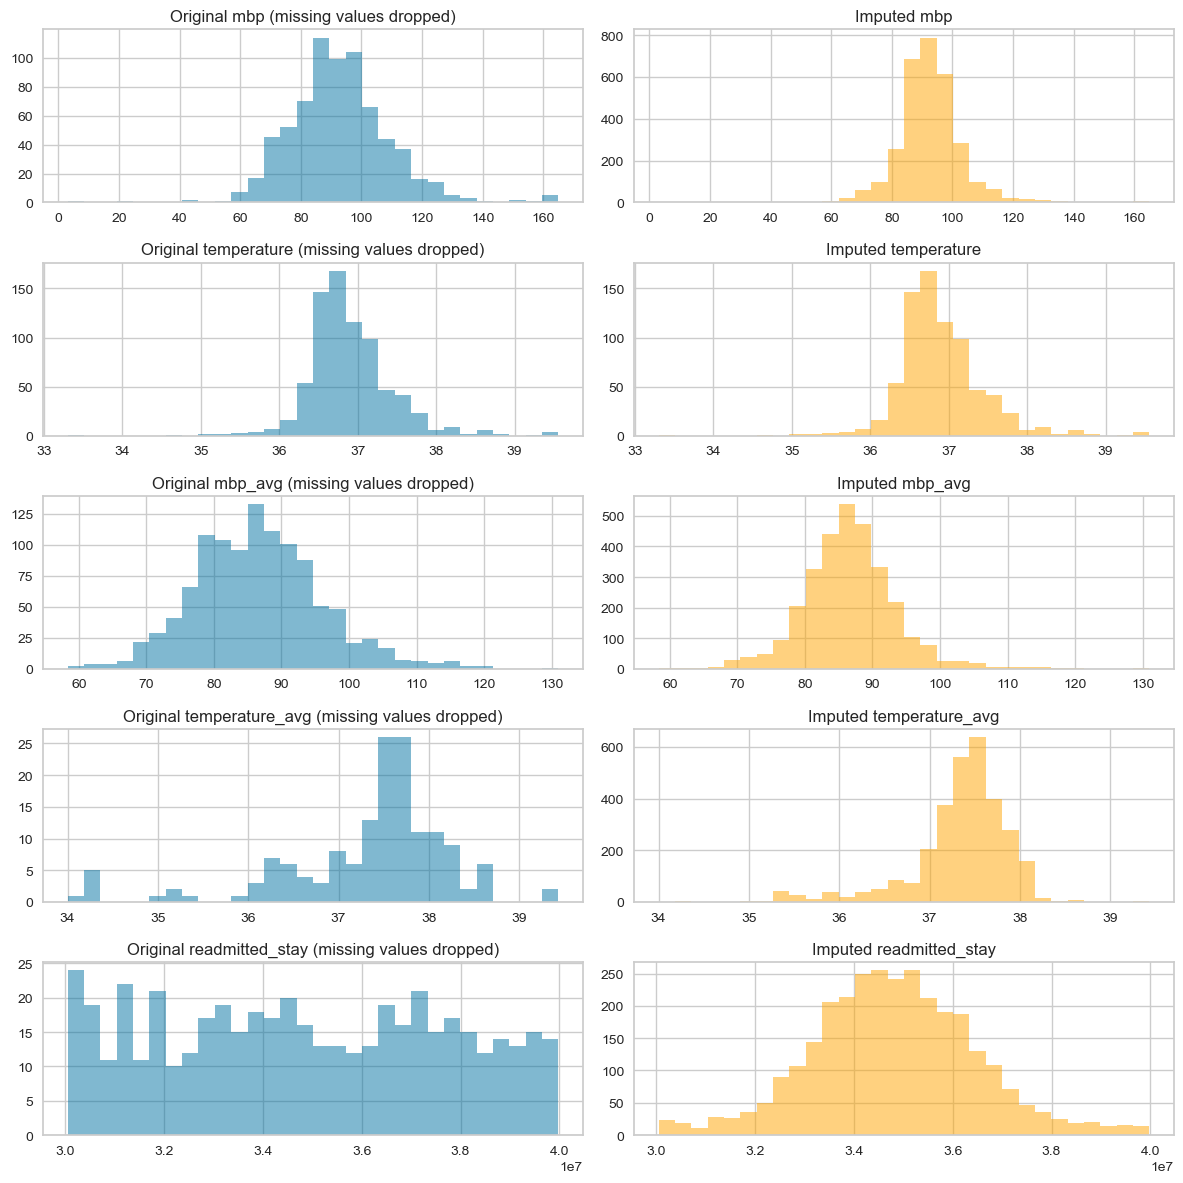

In [22]:
import matplotlib.pyplot as plt

# Plot distributions
plt.figure(figsize=(12, 12))

# Original data (with missing values dropped)
plt.subplot(5, 2, 1)
plt.hist(df['mbp'].dropna(), bins=30, alpha=0.5, label='Original')
plt.title('Original mbp (missing values dropped)')

# Imputed data - NOTE THE QUOTES AROUND 'spo2'
plt.subplot(5, 2, 2)
plt.hist(df_imputed['mbp'], bins=30, alpha=0.5, color='orange', label='Imputed')  # Fixed here
plt.title('Imputed mbp')

######

# Original data (with missing values dropped)
plt.subplot(5, 2, 3)
plt.hist(df['temperature'].dropna(), bins=30, alpha=0.5, label='Original')
plt.title('Original temperature (missing values dropped)')

# Imputed data - NOTE THE QUOTES AROUND 'spo2'
plt.subplot(5, 2, 4)
plt.hist(df_imputed['temperature'], bins=30, alpha=0.5, color='orange', label='Imputed')  # Fixed here
plt.title('Imputed temperature')

######

# Original data (with missing values dropped)
plt.subplot(5, 2, 5)
plt.hist(df['mbp_avg'].dropna(), bins=30, alpha=0.5, label='Original')
plt.title('Original mbp_avg (missing values dropped)')

# Imputed data - NOTE THE QUOTES AROUND 'spo2'
plt.subplot(5, 2, 6)
plt.hist(df_imputed['mbp_avg'], bins=30, alpha=0.5, color='orange', label='Imputed')  # Fixed here
plt.title('Imputed mbp_avg')

######

# Original data (with missing values dropped)
plt.subplot(5, 2, 7)
plt.hist(df['temperature_avg'].dropna(), bins=30, alpha=0.5, label='Original')
plt.title('Original temperature_avg (missing values dropped)')

# Imputed data - NOTE THE QUOTES AROUND 'spo2'
plt.subplot(5, 2, 8)
plt.hist(df_imputed['temperature_avg'], bins=30, alpha=0.5, color='orange', label='Imputed')  # Fixed here
plt.title('Imputed temperature_avg')

######

# Original data (with missing values dropped)
plt.subplot(5, 2, 9)
plt.hist(df['readmitted_stay'].dropna(), bins=30, alpha=0.5, label='Original')
plt.title('Original readmitted_stay (missing values dropped)')

# Imputed data - NOTE THE QUOTES AROUND 'spo2'
plt.subplot(5, 2, 10)
plt.hist(df_imputed['readmitted_stay'], bins=30, alpha=0.5, color='orange', label='Imputed')  # Fixed here
plt.title('Imputed readmitted_stay')


plt.tight_layout()
plt.show()


## 5. 📈 Visualización de Resultados

<Axes: >

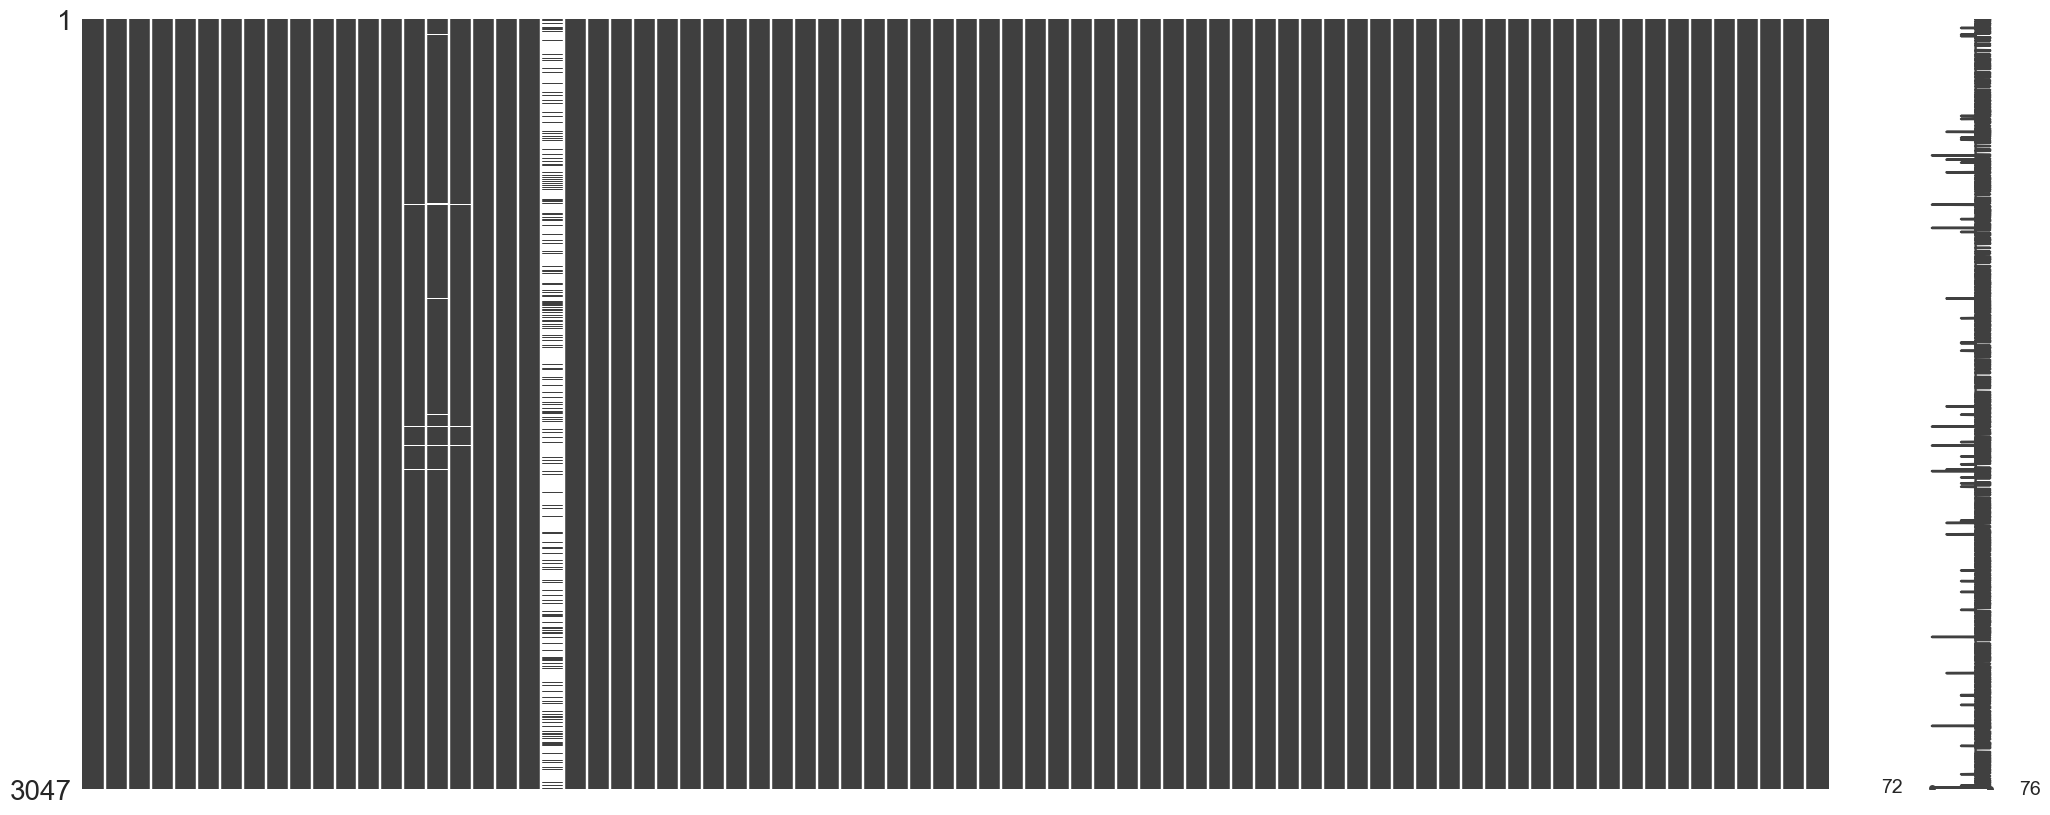

In [23]:

# Analitzem si els missings són per MCAR

import missingno as msno
msno.matrix(df_imputed)  # Busca patrons visuals (ex: columnes amb missings correlacionades)


Veiem que la gran majoria de dades s'han reemplenat segons algoritme KNN deixant només una columna sense dades.

In [28]:

# Calculate missing percentages of new truncated data

missing_pct = (df_imputed.isnull().sum() / len(df_imputed) * 100).round(2)
print("Missing percentages per column:")
print(missing_pct.sort_values(ascending=False))

# Set missing data threshold
missing_threshold = 60  # Exclude columns with >60% missing
columns_to_exclude = missing_pct[missing_pct > missing_threshold].index
print(f"\nColumns with >{missing_threshold}% missing: {list(columns_to_exclude)}")

# Exclude high-missingness columns, but keep readmitted_stay for target creation
features_to_keep = [col for col in df.columns if col not in columns_to_exclude or col == 'readmitted_stay']
df_clean2 = df.loc[:, features_to_keep]

# Handle Decimal values and fill NaNs
# Convert Decimal to float for numerical columns
numerical_cols = df_clean2.select_dtypes(include=['number', 'Int64', 'float64', 'int64']).columns
for col in numerical_cols:
    df_clean2.loc[:, col] = df_clean2[col].apply(lambda x: float(x) if isinstance(x, Decimal) else x)

# Identify integer columns
int_columns = df_clean2.select_dtypes(include=['Int64', 'int64']).columns
# Fill NaNs with rounded medians for integer columns
for col in int_columns:
    median_val = df_clean2[col].median()
    if not pd.isna(median_val):
        df_clean2.loc[:, col] = df_clean2[col].fillna(int(median_val))

# Fill NaNs for other numeric columns, excluding readmitted_stay and readmitted
numeric_cols = df_clean2.select_dtypes(include='number').columns.difference(['readmitted_stay', 'readmitted'])
df_clean2.loc[:, numeric_cols] = df_clean2[numeric_cols].fillna(df_clean2[numeric_cols].median())

# Handle readmitted_stay separately
df_clean2.loc[:, 'readmitted_stay'] = df_clean2['readmitted_stay'].fillna(0)

# Scale features
scaler = StandardScaler()
feature_cols = df_clean2.select_dtypes(include='number').columns[
    ~df_clean2.select_dtypes(include='number').columns.str.startswith(('non_ich', 'ich'))
].difference(['readmitted_stay', 'readmitted', 'subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'has_hypertension', 'has_hydrocephalus', 'has_cad', 'has_anticoagulation', 'had_neurosurgery'])
features_scaled = scaler.fit_transform(df_clean2[feature_cols])
df_clean2.loc[:, feature_cols] = features_scaled

# Remove columns that are not needed for the final dataset 
df_clean2 = df_clean2.drop(columns=['intime', 'outtime', 'subject_id', 'hadm_id', 'stay_id', 'readmitted_stay', 'all_diagnoses','ich_icd_codes'], errors='ignore')

df_clean2


Missing percentages per column:
subject_id                                                                                                                                                                                                              0.0
all_diagnoses_I615: Nontraumatic intracerebral hemorrhage, intraventricular; G936; E854; G8194; N390; F0390; I4891; R414; I10; M0820; I680; T45515A; Z66; K219; Z90710; Z85828; M549; M25559; E039; Z23; R42; Y92009    0.0
all_diagnoses_I615: Nontraumatic intracerebral hemorrhage, intraventricular; G936; G911; B370; F05; N390; Z781; I4891; I10; Z7901; Z853; E785; G4733; R339; K5900; R441                                                 0.0
all_diagnoses_I615: Nontraumatic intracerebral hemorrhage, intraventricular; G936; G919; K743; R4701; E222; R471; I609; H5340; I10; Z87891; R000; R509; D72829; R451; D649; Z781                                        0.0
all_diagnoses_I615: Nontraumatic intracerebral hemorrhage, intraventricular; G936; G935;

,gender,age,first_careunit,icu_los_hours,hosp_los_hours,discharge_location,hospital_expire_flag,gcs_verbal,gcs_motor,gcs_eyes,...,non_ich_J9601,non_ich_N179,non_ich_G8191,ich_431,ich_I618,ich_I615,ich_I611,ich_I619,ich_I610,ich_I614
0,-1.083917,-0.576412,1.366703,-0.580247,-0.390636,0.640592,0,0.0,4.0,1.0,...,0,0,0,1,0,0,0,0,0,0
1,-1.083917,0.060331,1.031921,-0.842865,-0.408808,0.640592,0,5.0,6.0,4.0,...,0,0,0,0,0,0,0,1,0,0
4,-1.083917,0.888096,1.031921,0.369648,-0.093066,1.009639,0,0.0,4.0,2.0,...,0,0,0,1,0,0,0,0,0,0
5,0.922580,0.824422,-0.641984,1.414533,0.152259,0.640592,0,5.0,6.0,3.0,...,0,0,0,0,1,0,0,0,0,0
6,0.922580,-0.767434,-0.307203,-0.552309,1.372070,0.640592,0,4.0,6.0,4.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,0.922580,0.760747,-0.641984,-0.412618,-0.213457,0.640592,0,3.0,6.0,4.0,...,0,0,1,0,0,0,1,0,0,0
4246,0.922580,0.760747,0.027578,0.526102,0.826903,1.009639,0,2.0,5.0,4.0,...,0,0,0,0,0,1,0,0,0,0
4247,-1.083917,0.442376,1.031921,-0.524371,-0.626875,0.640592,0,5.0,6.0,4.0,...,0,0,0,1,0,0,0,0,0,0
4248,0.922580,0.951770,-0.641984,0.263484,-0.411080,0.640592,0,5.0,6.0,4.0,...,0,0,0,0,0,0,0,1,0,0


Com hem vist en l'apartat anterior,. nomñes tenim missing del 70% a la columna de temperatura. La resta s'han omplert.
Ara procedim a posar flags als indicadors de missing data

In [25]:
# 1. Identificar columnes amb missings
cols_with_missing = df.columns[df.isnull().any()].tolist()
print("Columnes amb missings:", cols_with_missing)  # Exemple: ['spo2', 'mbp', 'temperature']

# 2. Afegir indicadors al DataFrame imputat
for col in cols_with_missing:
    df_imputed[f'{col}_was_missing'] = df[col].isnull().astype(int)

# 3. Verificar
print("\nResum d'indicadors creats:")
print(df_imputed.filter(like='_was_missing').sum())

Columnes amb missings: ['gcs_verbal', 'gcs_motor', 'gcs_eyes', 'heart_rate', 'mbp', 'resp_rate', 'temperature', 'spo2', 'mbp_avg', 'resp_rate_avg', 'spo2_avg', 'temperature_avg', 'dnr', 'dni', 'fullcode', 'cmo', 'wbc_min', 'hgb_min', 'hct_min', 'sodium_min', 'creatinine_min', 'glucose_min', 'inr_min', 'pt_min', 'readmitted_stay']

Resum d'indicadors creats:
gcs_verbal_was_missing           23
gcs_motor_was_missing            50
gcs_eyes_was_missing             14
heart_rate_was_missing         1553
mbp_was_missing                2340
resp_rate_was_missing          1227
temperature_was_missing        2289
spo2_was_missing               1719
mbp_avg_was_missing            1942
resp_rate_avg_was_missing         5
spo2_avg_was_missing              2
temperature_avg_was_missing    2893
dnr_was_missing                1283
dni_was_missing                1283
fullcode_was_missing           1283
cmo_was_missing                1283
wbc_min_was_missing              34
hgb_min_was_missing         

In [26]:
# Si KNN ha imputat només columnes numèriques
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
cols_with_missing = df[numeric_cols].columns[df[numeric_cols].isnull().any()].tolist()

In [126]:
# 2. Encode Categorical Variables

encoder = OneHotEncoder(drop='first', sparse_output=False)  # 'sparse_output' en lloc de 'sparse'
cat_encoded = encoder.fit_transform(df_imputed[['gender', 'discharge_location']])
df_encoded = pd.concat([df_imputed, pd.DataFrame(cat_encoded)], axis=1)

In [27]:
# 3. Fix Class Imbalance (Your readmitted is 3706 vs 546)

from sklearn.impute import SimpleImputer

# Per columnes numèriques
num_imputer = SimpleImputer(strategy='median')
df_imputed[numeric_cols] = num_imputer.fit_transform(df_imputed[numeric_cols])

# Per columnes categòriques
cat_imputer = SimpleImputer(strategy='most_frequent')
df_imputed[cat_cols] = cat_imputer.fit_transform(df_imputed[cat_cols])

# Eliminar columnes amb >90% NaN (si són irrelevants)
df_imputed = df_imputed.dropna(thresh=len(df_imputed)*0.1, axis=1)

# 3. Codificar categòriques (asegurar noms string)
df_imputed = pd.get_dummies(df_imputed, drop_first=True)
df_imputed.columns = df_imputed.columns.astype(str)

try:
    # Assegura que totes les columnes són strings
    df_imputed.columns = df_imputed.columns.astype(str)
    
    # Separa features i target
    X = df_imputed.drop('readmitted', axis=1)
    y = df_imputed['readmitted']
    
    # Verifica que no hi hagi NaN
    assert X.isna().sum().sum() == 0, "Hi ha NaN a X"
    assert y.isna().sum() == 0, "Hi ha NaN a y"
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.3, 
        stratify=y,
        random_state=42
    )
    
    # Aplica SMOTE
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    
    print("Resampling completat amb èxit!")
    print(f"Distribució original: {Counter(y_train)}")
    print(f"Distribució després de SMOTE: {Counter(y_resampled)}")
    
except Exception as e:
    print(f"Error: {str(e)}")
    print("Tipus de dades a X_train:", X_train.dtypes.value_counts())
    print("Valors únics a y_train:", y_train.unique())


Error: name 'SMOTE' is not defined
Tipus de dades a X_train: bool              3049
float64             67
int64               25
datetime64[us]       2
Name: count, dtype: int64
Valors únics a y_train: [0. 1.]


In [154]:
# 4. Hyperparameter Tuning (Key for Accuracy)



## 6. 🚀 Despliegue (Futuro)
Se puede utilizar Hugging Face Spaces o Streamlit Cloud para desplegar un frontend que permita:
- Cargar variables clínicas
- Obtener un score de riesgo
- Visualizar el gráfico ROC o una matriz de confusión